In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import re
import numpy as np

%matplotlib inline

import os
from scipy.stats import itemfreq

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle

In [4]:
DATA_ROOT = 'Data'
DB_NAME = 'amiunique-1month-aug17.sqlite3.db'

PATH_TO_DB = os.path.join(DATA_ROOT, DB_NAME)

In [5]:
con = sqlite3.connect(PATH_TO_DB)
df = pd.read_sql_query('select * from fpData', con)

In [6]:
# multicolumn label encoder (borrowed from Stockoverflow) to encode categorical values, added .astype(str)

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        '''
        Note that .fit returned self: this is standard behavior for .fit methods in scikit-learn.
        '''
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

X = MultiColumnLabelEncoder(columns = None).fit_transform(df.astype(str))

## Dimension Reduction

PCA - linear dimensionality reduction of the data to project it to a lower dimensional space. Normalize, apply PCA (comp. explain ~64%, 23%, 6% of variance), look for discrete spaces (dots) that are not typical.

In [7]:
X_normalized = preprocessing.normalize(X, norm='l2', axis=1, copy=True)

In [8]:
pca = PCA(n_components=3)
reduced3 = pca.fit_transform(X_normalized)
reduced3.shape
pca.components_
pca.explained_variance_
pca.explained_variance_ratio_
pca.explained_variance_ratio_.sum()

0.93394535401382417

In [9]:
X['pca1'] = reduced3[:,0]
X['pca2'] = reduced3[:,1]
X['pca3'] = reduced3[:,2]
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int) # creates a column of Boolean True or False values and .astype(int) # converts True/False to 1/0
# calculate 'frequency' columns for api keys per each hour in the dataset
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
# create a new column for frequent ids if the same user has accessed the site >10 times in given hour (mark as 1, otherwise 0)
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>10, 1, 0)

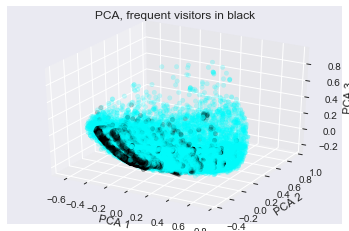

In [10]:
# plotting frequent visitors
fig = plt.figure()
labl = X['frequent/hour']
color= ['cyan' if l == 0 else 'black' for l in labl]
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['pca1'], X['pca2'], X['pca3'], c=color, marker='o', alpha = .2)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('PCA, frequent visitors in black')
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)
plt.show()

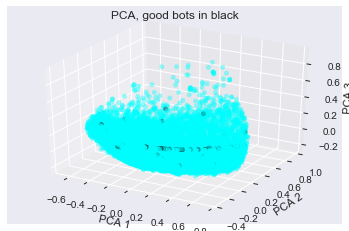

In [11]:
# plotting good bots
fig = plt.figure()
labl = X['GoodBot']
color= ['cyan' if l == 0 else 'black' for l in labl]
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['pca1'], X['pca2'], X['pca3'], c=color, marker='o', alpha = .4)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('PCA, good bots in black')
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)
plt.show()

In [12]:
pca2 = PCA(n_components=2)
#  unsupervised dimensionality reduction
reduced2 = pca2.fit_transform(X_normalized)
pca2.explained_variance_ratio_

array([ 0.64134541,  0.23336855])

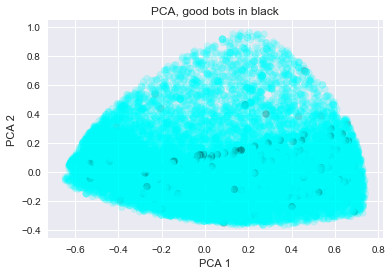

In [13]:
X['pca2.1'] = reduced2[:,0]
X['pca2.2'] = reduced2[:,1]
figr = plt.figure()
label = X['GoodBot']
color= ['cyan' if l == 0 else 'black' for l in label]
ax = figr.add_subplot()
plt.scatter(X['pca2.1'], X['pca2.2'], c=color, alpha = .2)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA, good bots in black')
plt.show()